In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

In [2]:
def generate_random_weighted_graph(n,n_edges,low,high,seed=1):
    g = nx.generators.gnm_random_graph(n,n_edges,seed=seed)
    # add random weights to the graph
    g.add_weighted_edges_from([(a,b,np.random.randint(low,high)) for a,b in g.edges()])
    # creare layout fro plotting and set pos as attribute
    nx.set_node_attributes(g,nx.spring_layout(g),"pos") 
    return g

def plot_graph(g,title="",highlight_edges=[]):
    pos = nx.get_node_attributes(g,"pos")
    plt.figure(figsize=(30,30))
    plt.title(title)
    nx.draw(g,pos=pos,labels = {x:x for x in g.nodes},width=2)
    weights = nx.get_edge_attributes(g,"weight")
    # highlight highlighted_edges
    nx.draw_networkx_edges(g,pos,edgelist = highlight_edges,edge_color="r",width=2)
    # draw labels for edges
    nx.draw_networkx_edge_labels(g,pos,edge_labels=weights);
    # highlight labels of highlighted edges
    nx.draw_networkx_edge_labels(
        g,pos,
        edge_labels={
            e:w 
            for e,w in weights.items() 
            if e in map(lambda x:tuple(sorted(x)),highlight_edges)
        },
        font_color="r"
    );
    plt.show()

In [3]:
def zero_divide(a,b):
    '''Utility function to remove divide by zero error'''
    return np.divide(a,b, out = np.zeros_like(a),where=b!=0)

class ACOTSP:
    def __init__(self,g,n_ants = 100, alpha=1,beta=5,Q=100,rho = .6) -> None:
        self.g = g # networkx graph
        self.n_nodes = len(g.nodes)
        distances = nx.to_numpy_array(g)
        self.visibility = zero_divide(np.ones_like(distances),distances) # visibility \nu_ij= 1/d_ij without self
        self.n_ants = n_ants
        self.alpha = alpha
        self.beta = beta
        self.Q = Q
        self.rho= rho
        self.phe_trail = np.ones((self.n_nodes,self.n_nodes))

    def compute_prob(self,visited):
        self.prob = self.phe_trail**self.alpha*self.visibility**self.beta
        self.prob[:,np.array(list(visited))] = 0 # zeroing out visited nodes/columns
        prob_sum = self.prob.sum(-1,keepdims=True)
        self.prob = zero_divide(self.prob,prob_sum) # normalization - divide by row sum
        return self.prob
        
    def initialize(self):
        nodes = list(self.g.nodes)
        self.ant_pos = np.random.choice(nodes,self.n_ants)
    
    
    def path_length(self,path):
        edge_weights = nx.get_edge_attributes(self.g,"weight")
        return sum((edge_weights[tuple(sorted(edge))] for edge in path))
            
    def ant_tour(self,k):
        current = self.ant_pos[k]   
        visited = {current}
        path = []
        self.compute_prob(visited)

        while True:
            prev = current
            current = np.random.choice(self.n_nodes, p = self.prob[current])
            visited.add(current)
            path.append((prev,current))
            if np.all(self.prob[current]==0):
                break
            self.compute_prob(visited)
        self.paths[k] = path

    def update_pheromone_trails(self):
        d_phe_trail = np.zeros((self.n_nodes,self.n_nodes,self.n_ants))
        for k in range(self.n_ants):
            if len(self.paths[k])==self.n_nodes-1:
                for i,j in self.paths[k]:
                    d_phe_trail[i,j,k]= d_phe_trail[j,i,k] = self.Q/self.path_lengths[k]
        d_phe_trail = d_phe_trail.sum(-1)
        self.phe_trail = self.rho*self.phe_trail + d_phe_trail
        
    def run(self,n_iter = 1):
        self.initialize()
        for t in range(n_iter):
            self.paths= [0 for _ in range(self.n_ants)]
            for k in range(self.n_ants):
                self.ant_tour(k)
            self.path_lengths = list(map(self.path_length,self.paths))
            self.update_pheromone_trails()
            self.hamiltonian_paths = [path for path in self.paths if len(path) == self.n_nodes -1]
            self.hamiltonian_path_lengths = list(map(self.path_length,self.hamiltonian_paths))
            print("Min hamiltonian Path length:",self.min_path_length)
            
    
    @property
    def min_path_length(self):
        try:
            return min(self.hamiltonian_path_lengths)
        except:
            return None
    @property
    def min_path(self):
        try:
            return self.hamiltonian_paths[np.argmin(self.hamiltonian_path_lengths)]
        except:
            return None
        

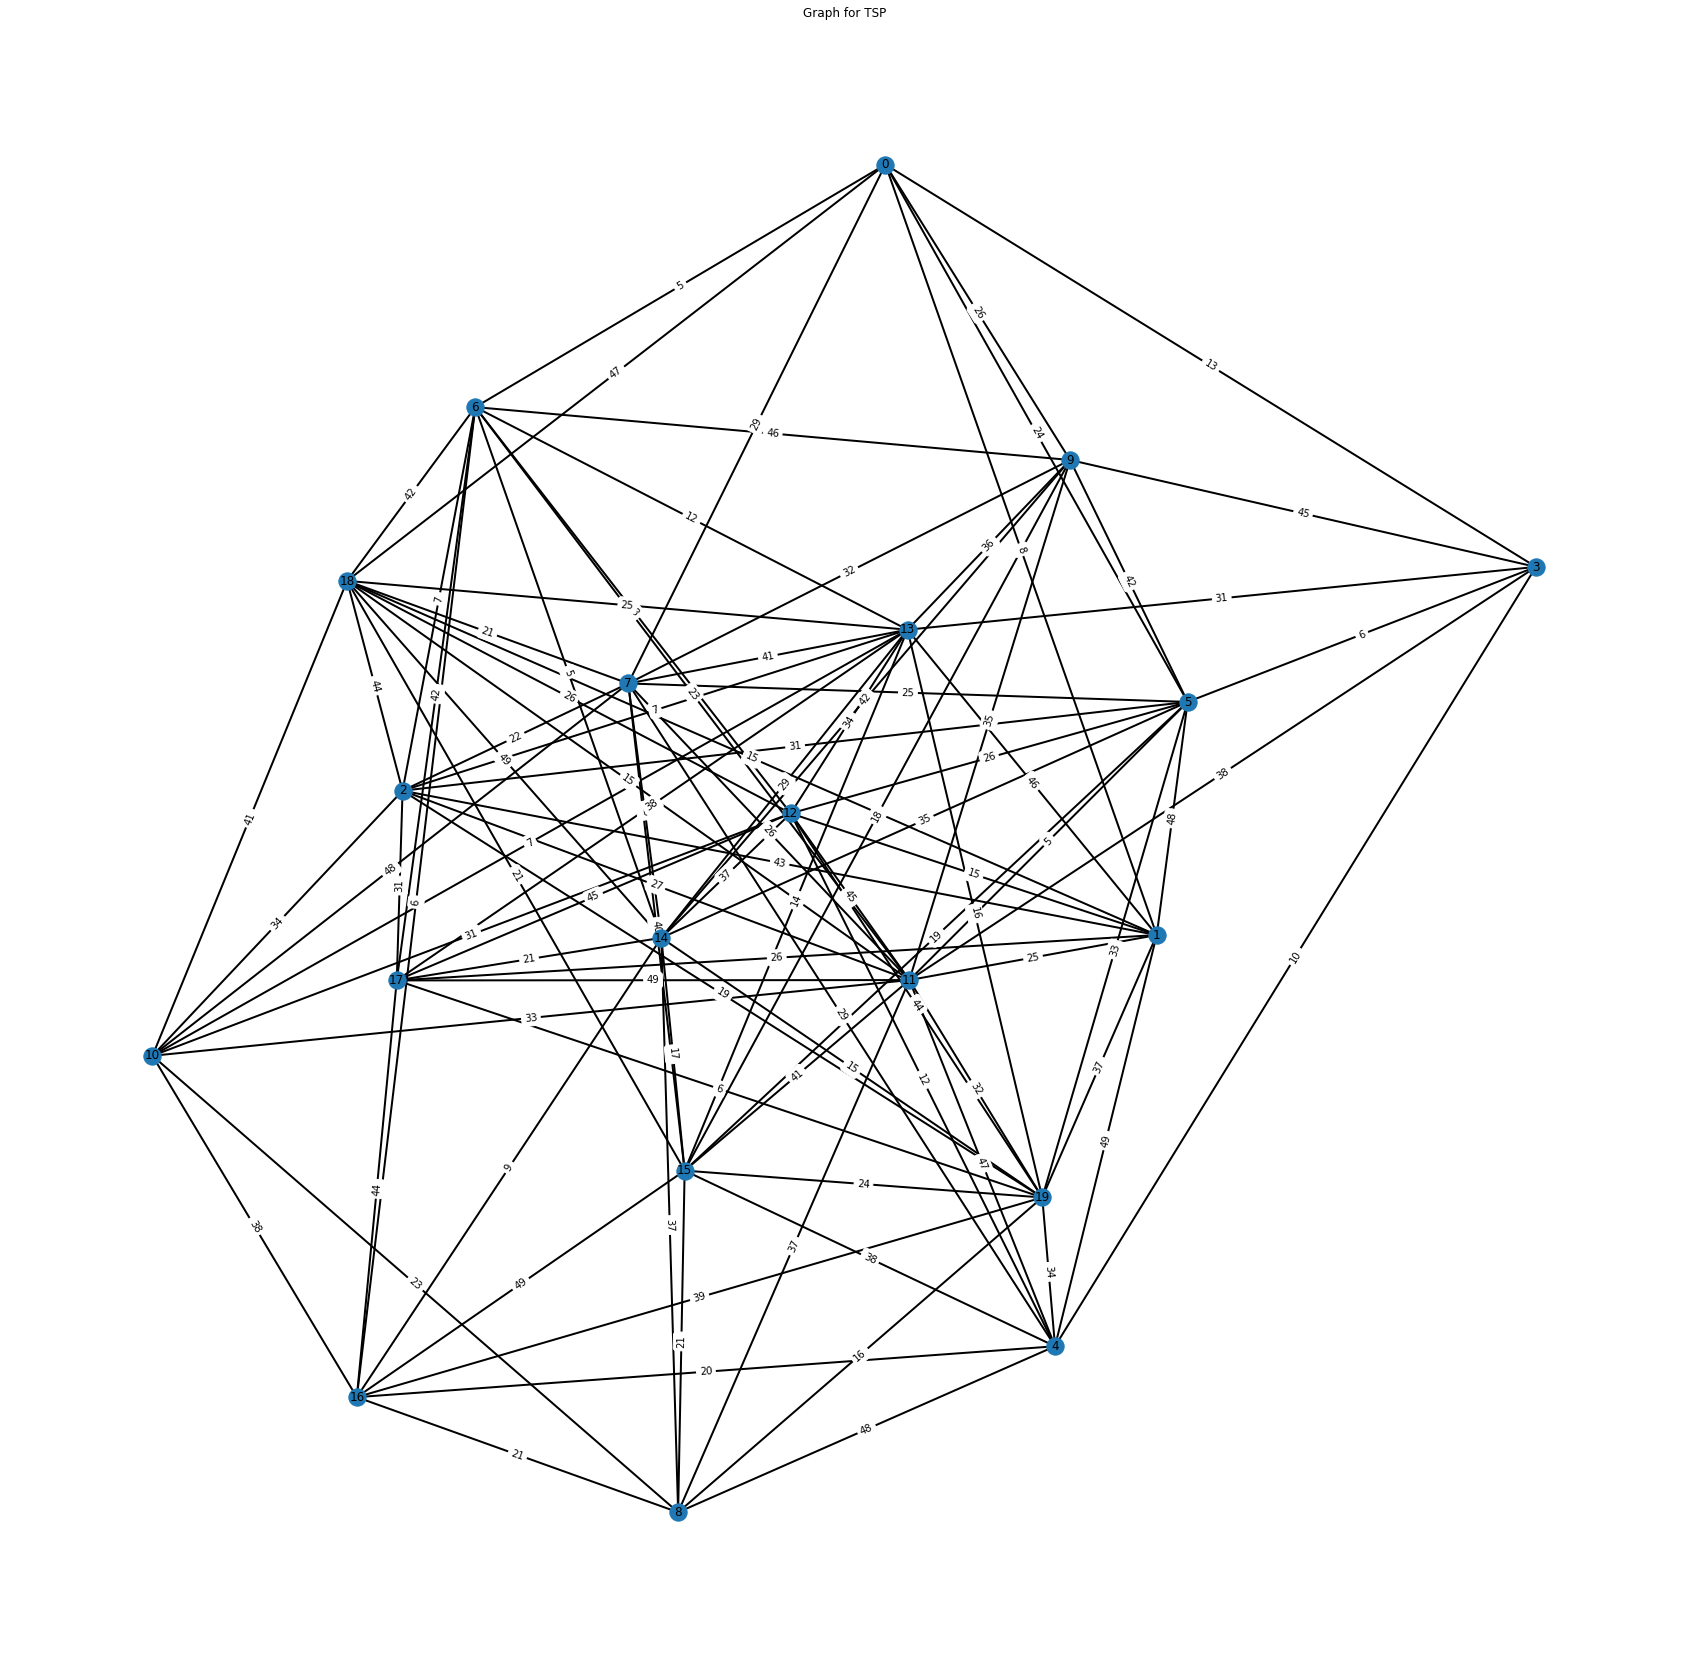

Min hamiltonian Path length: 256
Min hamiltonian Path length: 245
Min hamiltonian Path length: 235
Min hamiltonian Path length: 239
Min hamiltonian Path length: 242
Min hamiltonian Path length: 250
Min hamiltonian Path length: 242
Min hamiltonian Path length: 226
Min hamiltonian Path length: 247
Min hamiltonian Path length: 250
Min hamiltonian Path length: 242
Min hamiltonian Path length: 250
Min hamiltonian Path length: 250
Min hamiltonian Path length: 242
Min hamiltonian Path length: 256
Min hamiltonian Path length: 256
Min hamiltonian Path length: 250
Min hamiltonian Path length: 250
Min hamiltonian Path length: 245
Min hamiltonian Path length: 250
Min hamiltonian Path length: 237
Min hamiltonian Path length: 249
Min hamiltonian Path length: 250
Min hamiltonian Path length: 250
Min hamiltonian Path length: 240
Min hamiltonian Path length: 240
Min hamiltonian Path length: 244
Min hamiltonian Path length: 250
Min hamiltonian Path length: 250
Min hamiltonian Path length: 235
Min hamilt

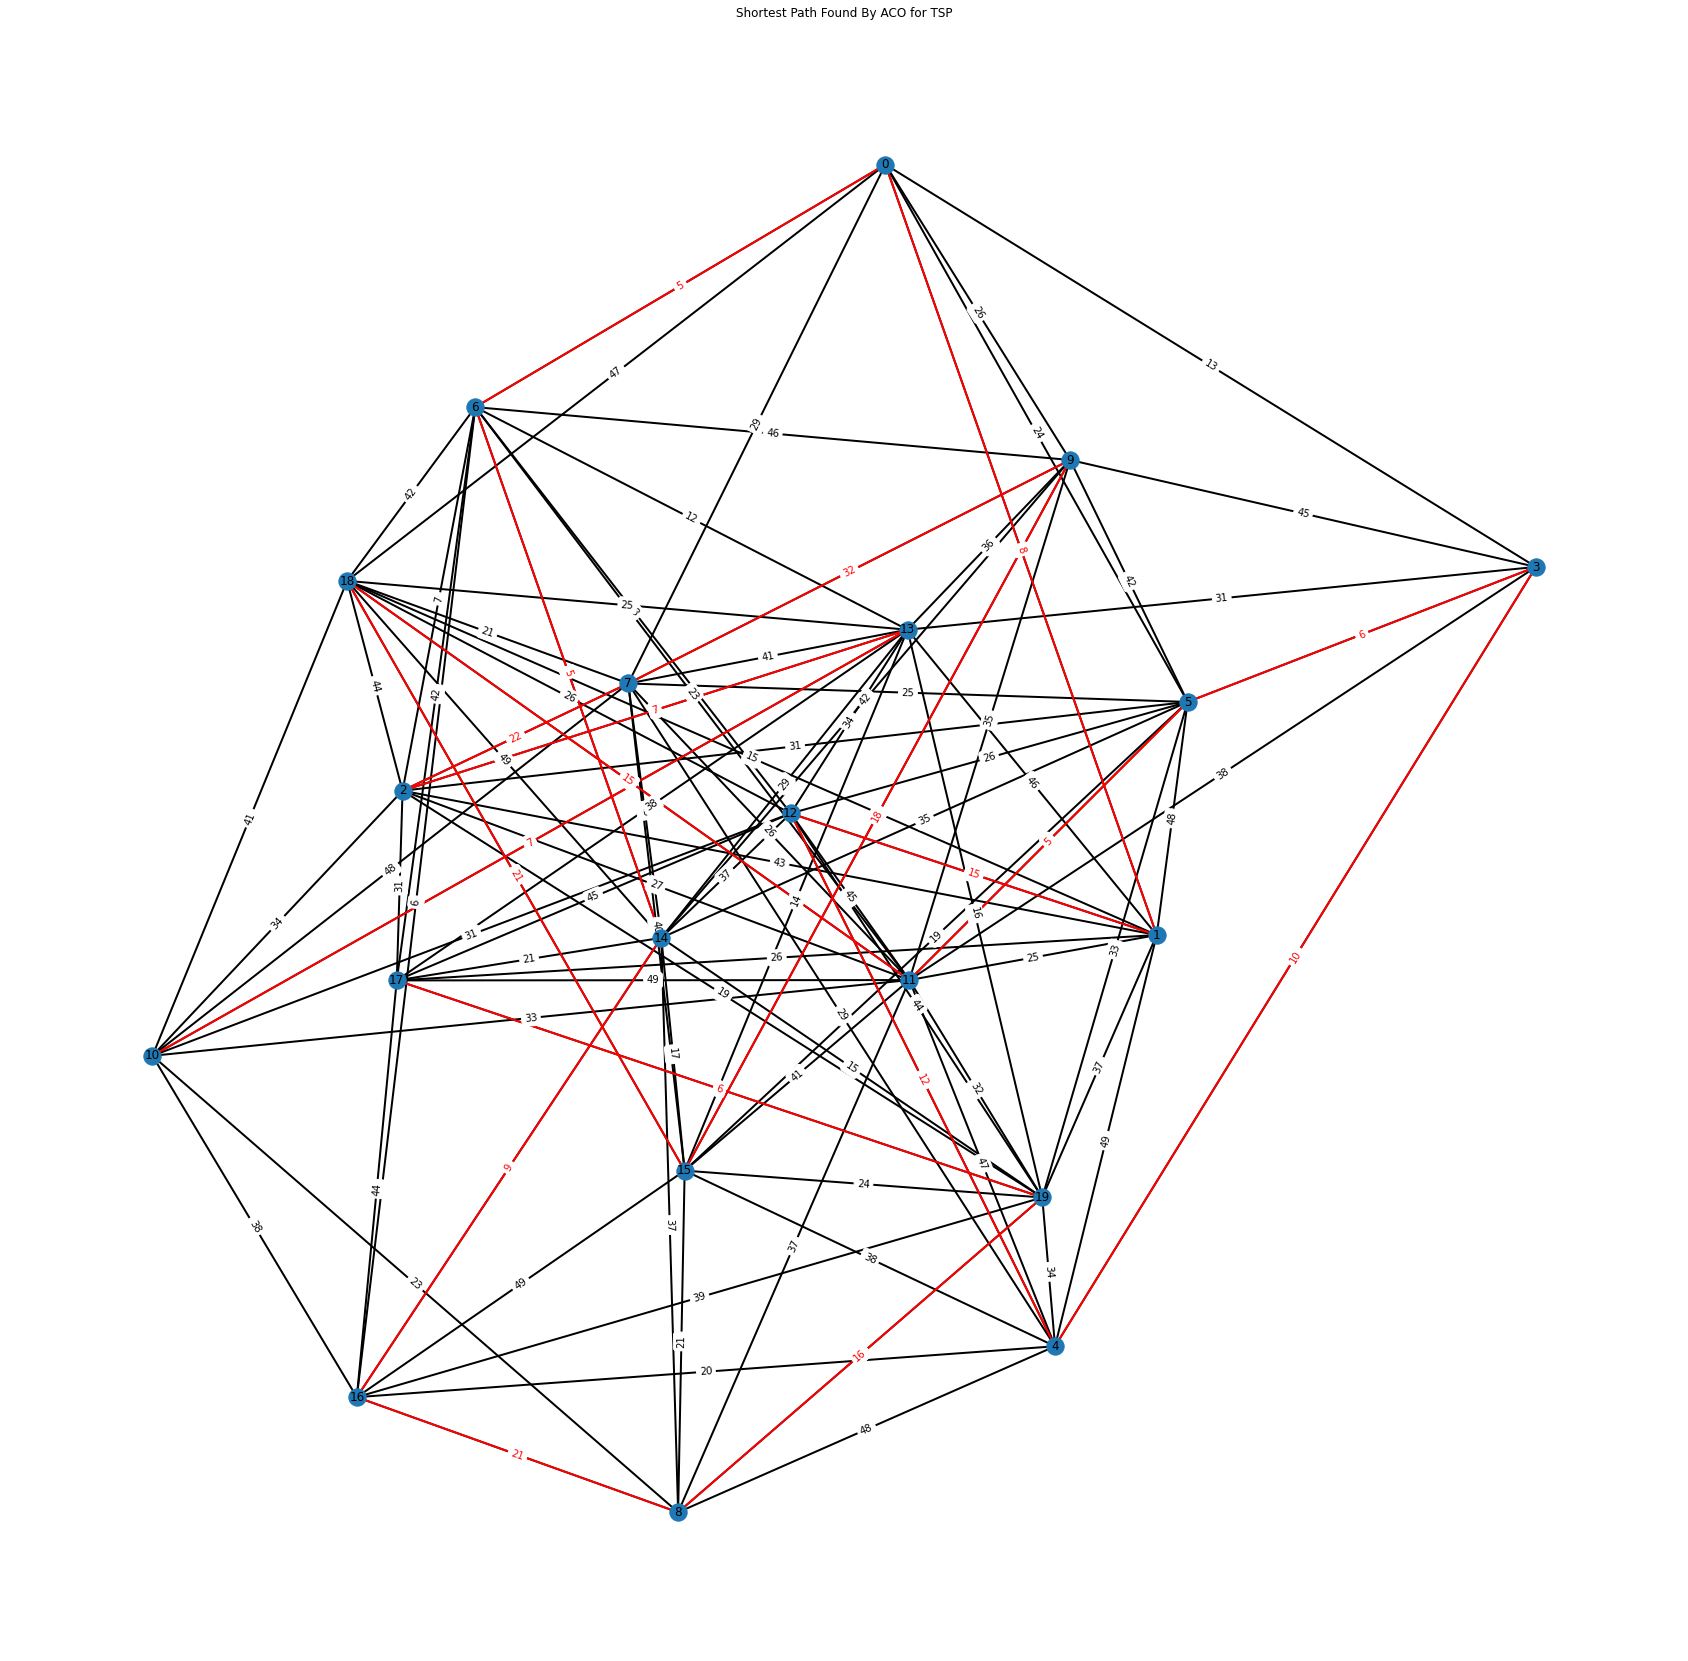

In [4]:
np.random.seed(3)
g = generate_random_weighted_graph(20,100,5,50,seed=10)
random_edges = np.random.choice(len(g.edges),5,replace=False)
plot_graph(g,"Graph for TSP")
acotsp = ACOTSP(g,n_ants=50,alpha=1,beta=5,Q=100,rho=.5)
acotsp.run(n_iter = 100)
plot_graph(g,"Shortest Path Found By ACO for TSP",acotsp.min_path)